In [1]:
# Adapting the 1DHT model from Hornum et al. (2020) from MATLAB to Python

In [1]:
import numpy as np
from scipy.interpolate import interp1d
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

In [2]:
#      Constants and general model setup
toyr =60*60*24*365     # to year from s

            # Thermal properties of water and ice (from Williams and Smith, 1989) %%%
            
p_w = 1000             # density [kg/m3]
p_ice = 917
cp_w = 4180            # specific heat capacity [J/(kg*K)]
cp_ice = 2100
k_w = 0.56*toyr        # thermal conductivity [(J/yr)/(m K)]
k_ice = 2.24*toyr
L=333.6*1000           # Latent heat of fusion [J/kg]

            ## Porosity and thermal properties of CERES materials ##
            
n_Sc=2                 # Porosity scenario is chosen here: 1=minimum n, 2=intermediate n, 3=maximum n
nLob=[0.33, 0.5, 0.66]    ## [min interm. max] Lobate (thermal model; 6B) ##


                    ### Material 1 - Lobate
nL = nLob[n_Sc]        
p_soilL = 1300       ## DENSITY (thermal model; 2B)             
cp_soilL = 1538       ## HEAT CAPACITY; GRAB FROM JULIE'S DATABASE (this is going to be tricky with    
k_soilL = 1.3*toyr   ## THERMAL CONDUCTIVITY; GRAB FROM JULIE'S DATABASE (20% ice, 45% hydrates)       
aQ=k_soilL/(p_soilL*cp_soilL) #THERMAL DIFFUSIVITY [m^2/yr]


            ### Model parameters ###
tstep=0.05         # time step [yr] this is the minimum time step with our material properties
ts_1yr=1/tstep     # number of time steps in a year; 20
dz=2               # cell size [m]
grid_depth=600     ## grid depth, GRID SPANS 600m (depth of lobate flow) (domain constraints; 5B)
z=np.arange(0,grid_depth+dz,dz) # cell nodes, 0,2,4,6 M ETC.
nocell=len(z)    # number of cells
print(nocell)

301


In [3]:
 ### Temperature ###
Kv= -273.15              # set to -273.15 if in Kelvin. 0 if in C
T_gradient=0.00273    ## Thermal gradient [K/m] (Raymond et al. 2020) (thermal model; 7B)
T_0=273           # Initial surface temperature - NOT USED if temperature reconstruction is defined
T_end=350 # Initial temperature at bottom of grid - NOT USED in for loop (estimate from Bowling)
T_ini=np.zeros(nocell) # Initial temperature distribution, gives every cell node a temperature
for i in range(len(T_ini)):
    if 0 <= i < 2:
        T_ini[i] = 150
    elif 2 <= i < (nocell-1)/2:
        T_ini[i] = (((300-150)/(300))*z[i]) + 150
    #elif i == (nocell-1)/2:
    #    T_ini[i] = 273
    #elif i > (nocell-1)/2:
    #    T_ini[i] = (((150-273)/300)*z[i-150]) + 273
    #if i == grid_depth:
    #    T_ini[i] = 273
    else:
        T_ini[i] = 300
#T_ini[-1] = 150
print(T_ini)
len(T_ini)

[150. 150. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163.
 164. 165. 166. 167. 168. 169. 170. 171. 172. 173. 174. 175. 176. 177.
 178. 179. 180. 181. 182. 183. 184. 185. 186. 187. 188. 189. 190. 191.
 192. 193. 194. 195. 196. 197. 198. 199. 200. 201. 202. 203. 204. 205.
 206. 207. 208. 209. 210. 211. 212. 213. 214. 215. 216. 217. 218. 219.
 220. 221. 222. 223. 224. 225. 226. 227. 228. 229. 230. 231. 232. 233.
 234. 235. 236. 237. 238. 239. 240. 241. 242. 243. 244. 245. 246. 247.
 248. 249. 250. 251. 252. 253. 254. 255. 256. 257. 258. 259. 260. 261.
 262. 263. 264. 265. 266. 267. 268. 269. 270. 271. 272. 273. 274. 275.
 276. 277. 278. 279. 280. 281. 282. 283. 284. 285. 286. 287. 288. 289.
 290. 291. 292. 293. 294. 295. 296. 297. 298. 299. 300. 300. 300. 300.
 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300.
 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300.
 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300. 300.
 300. 

301

In [4]:
indices = np.where(T_ini == 273)[0]
print(indices)

[123]


In [5]:
# Ceres temperature reconstruction (just a .txt file) with 100k rows each with a temp of 150 K
# Load the data from the text file
TCurve_data = pd.read_csv('cerestempcurve.txt', header=None)

T_ann10 = TCurve_data[1] #temperatures
tt_yr = TCurve_data[0] #years

ttt = np.arange(0, 100000+tstep, tstep) #do this for maximum runtime, can filter down later
interp_function = interp1d(tt_yr, T_ann10, kind='linear', fill_value='extrapolate')

T_ann10q = interp_function(ttt) #interpolating the surface temperature so there is one for every time step

print(T_ann10q[-1])

150.0


In [6]:
len(T_ann10q) #this is the amount of time steps if we were to run it for 100000 years

2000001

In [7]:
### Assigning material IDs to the different model grids and creating empty vectors and matrices. ###
### For now, we are only doing one column and one material ID (lobate) ###

# 1=Lobate
onegrid=np.ones(nocell) # 1 x 301 matrix

                # Material IDs ZONEs 2-3 (3), 1-2 (2), 0-1 (1)
Z0_1MatID=np.ones(nocell) #setting entire domain to same material

            ### Creating one-vectors and empty matrices used in for-loop ###
n_grid=np.ones(nocell) # all of these have nocell elements -> all material properties define at nodes (1 x nocell matrix)
p_soil=np.ones(nocell)
cp_soil=np.ones(nocell)
k_soil=np.ones(nocell)

F_w = np.zeros(nocell) #all cells have 0 percent water except for bottom (this was from the original code, but 
                       # need to think about this more)
F_w[nocell-1] = 1

f_w = np.ones(nocell) ##fraction of liquid water in the pore space
f_w[0] = 0
f_w[1] = 0 ##top two cells are carapace

F_ice = np.zeros(nocell) #initiate model when all cells (besides carapace) are above freezing temp
#F_ice[0] = 0
#F_ice[1] = 0

f_ice = np.zeros(nocell)
#f_ice[0]=0      
#f_ice[1]=0


dF_w=np.zeros(nocell-1) ## CHANGE IN TOTAL FRACTION OF WATER??? 
k_eq=np.zeros(nocell-1) ## EQUIVALENT THERMAL CONDUCTIVITY
C_eq=np.zeros(nocell)   ## EQUIVALENT HEAT CAPACITY
a_eq=np.zeros(nocell)   ## EQUIVALENT THERMAL DIFFUSIVITY

runtime = 10000

T_matx_0_1=np.zeros((nocell,runtime)) ### CREATING EMPTY TEMP MATRICES FOR EACH ZONE'S RUN TIME (100000 yr)
#T_matx_0_1[:,0] = T_ini.copy()                                    ### add more as needed

F_matx_0_1=np.zeros((nocell,runtime)) # NOT SURE WHAT F MEANS, IS THIS FRACTION OF WATER OF EACH CELL IN EACH ZONE?
F_matx_0_1[:,0] = F_ice.copy()

w=0.957725     # Correction factor, DESCRIBED IN SECTION 4.1 IN PAPER, T_S = -2 ºC, T_L = 0 ºC

In [8]:
### Numerical Model ###
### Only writing for one column ###

col_incl=[1]       ### Specify which of the 12 columns (zones) to include in the ground temperature simulation (e.g. [1:12] (all), [4] (only one), [1 5 11] (several specific ones).
for col in col_incl:
    if col==1:            ### Defining the column in use
        runtime=10000      # Simulation runtime
        materialid=Z0_1MatID
        
for ii in range(nocell): #applying material properties to each cell in the domain
    if materialid[ii] == 1:
        n_grid[ii] = onegrid[ii] * nL
    if materialid[ii] == 1:
        p_soil[ii] = onegrid[ii] * p_soilL
    if materialid[ii] == 1:
        cp_soil[ii] = onegrid[ii] * cp_soilL
    if materialid[ii] == 1:
        k_soil[ii] = onegrid[ii] * k_soilL
    if materialid[ii] == 2:
        n_grid[ii] = onegrid[ii] * nL
    if materialid[ii] == 2:
        p_soil[ii] = onegrid[ii] * p_ice
    if materialid[ii] == 2:
        cp_soil[ii] = onegrid[ii] * cp_ice
    if materialid[ii] == 2:
        k_soil[ii] = onegrid[ii] * k_ice

f_w[nocell-1] = n_grid[nocell-1]*1
f_ice[0] = n_grid[0]*1   
f_soil = 1-n_grid

no_tstep = int(runtime / tstep)  # Total number of time steps, DIFFERENT FOR EACH ZONE

T_11 = T_ann10q[:no_tstep + 1]  # Cutting temperature curve to simulation period
T_1 = np.flip(T_11)  # New T_1 #This is just 150 K for each time step

In [9]:
print(p_soil)

[1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300.
 1300. 1300. 1300. 1300. 1300. 1300. 1300. 1300. 13

In [10]:
### stability criterion ###
# calculates the effective thermal diffusivity of the soil and ice material
# if stability < 0.5, model will proceed

k_s_ice = ((n_grid * np.sqrt(k_ice)) + ((1-n_grid) * np.sqrt(k_soil))) ** 2
C_s_ice = (n_grid * p_ice * cp_ice) + ((1 - n_grid) * p_soil * cp_soil)
a_s_ice = k_s_ice / C_s_ice
stability = (np.max(a_s_ice) * tstep / dz**2)
print(stability)

0.3823027147652911


In [11]:
#temperature array used in numerical model

T = np.zeros((nocell, no_tstep))
T[:, 0] = T_ini.copy()

print(T)
T.shape

[[150.   0.   0. ...   0.   0.   0.]
 [150.   0.   0. ...   0.   0.   0.]
 [152.   0.   0. ...   0.   0.   0.]
 ...
 [300.   0.   0. ...   0.   0.   0.]
 [300.   0.   0. ...   0.   0.   0.]
 [300.   0.   0. ...   0.   0.   0.]]


(301, 200000)

In [12]:
### Numerical Model ###
### heat transfer loop starts
if col==1:
    xT_ini = T_ini.copy()
    k = 0 #time step count
    l = 0 #year count
    for t in range(no_tstep):
        if stability > 0.5:
            break
        k += 1
        for i in range(1, nocell-1): #excluding top bc it has prescribed fractions
            if xT_ini[i] < 271.15: #solidus temperature of water
                F_w[i] = 0
            elif xT_ini[i] > 273: #liquidus
                F_w[i] = 1
            else:
                F_w[i] = np.exp(-(xT_ini[i] / w) ** 2)  # eq. A, Freezing curve
            F_ice[i] = 1 - F_w[i]

            if xT_ini[i] < -2:
                dF_w[i] = 0
            elif xT_ini[i] > 0:
                dF_w[i] = 0
            else:
                dF_w[i] = -2 * xT_ini[i] * np.exp(-(xT_ini[i] / w) ** 2)  # derivative of eq. A in paper
            
            f_w[i] = F_w[i] * n_grid[i]
            f_ice[i] = F_ice[i] * n_grid[i]

            #calculating equivalent material properties
            k_eq[i] = ((f_soil[i] * np.sqrt(k_soil[i])) + (f_w[i] * np.sqrt(k_w)) + (f_ice[i] * np.sqrt(k_ice))) ** 2
            C_eq[i] = (f_soil[i] * p_soil[i] * cp_soil[i]) + (f_w[i] * p_w * cp_w) + (f_ice[i] * p_ice * (cp_ice + L * dF_w[i]))
            a_eq[i] = k_eq[i] / C_eq[i]

            if (xT_ini[i + 1] - xT_ini[i - 1]) != 0:
                T[i, t] = (((a_eq[i]*tstep)/dz**2) * (xT_ini[i + 1] + xT_ini[i - 1])) + (xT_ini[i] * (1 - ((2*a_eq[i]*tstep)/dz**2)))
            else:
                T[i, t] = xT_ini[i]
            
            T[0, t] = T_1[t] #setting the top boundary to 150 K
            T[nocell - 1, t] = T[nocell - 2, t] + dz * T_gradient #this can be changed to whatever we want the bottom boundary to be
            
        xT_ini = T[:, t]      ### Value used in loop
                
        a_eq_0_1=a_eq.copy()      ### Vectors for figures         <<<<<<<<<<<<<<<--------------------
        C_eq_0_1=C_eq.copy()
        F_w_0_1=F_w.copy()
        F_ice_0_1=F_ice.copy()
        
         ### Creating a matrix with the temperature distribution for each year
        if k==ts_1yr: # IF ALL TIME STEPS WERE COMPLETED IN ONE YEAR,
            if l != runtime:
                ## UPDATES THE MATRICES FOR EACH COLUMN: ONE TEMP PER CELL PER YEAR
                # updates column of T matrix w temps from time step
                T_matx_0_1[:,l]=T[:,t].copy()     ### Vectors for figures         <<<<<<<<<<<<<<<--------------
                F_matx_0_1[:,l]=F_w[i].copy()
                l+=1 # INCREASE TO NEXT YEAR
                k=0
            elif l == runtime:
                l += 1
                k = 0
print('complete')

complete


In [14]:
T.shape

(301, 200000)

In [15]:
T_matx_0_1.shape 

(301, 10000)

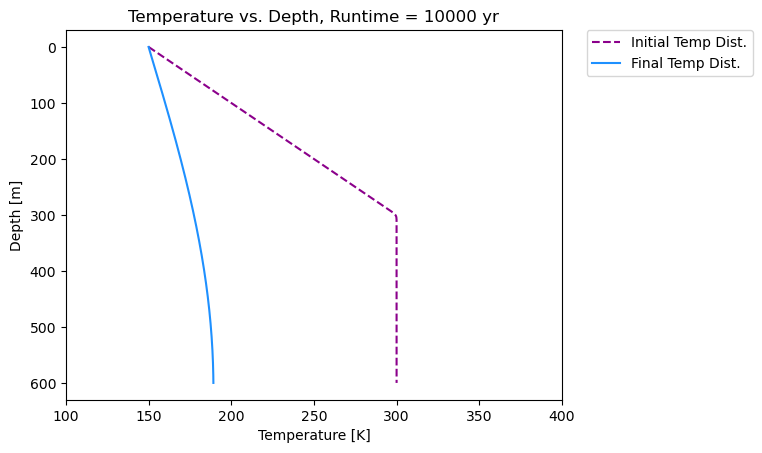

In [16]:
### Fig - Final temperature distrubution
#plotting curves for initial and final temp distributions

plt.xlim([100,400])
plt.plot(T_matx_0_1[:,0], z, linestyle='dashed',color='darkmagenta', label='Initial Temp Dist.')
plt.plot(T_matx_0_1[:,runtime-1], z, color='dodgerblue', label='Final Temp Dist.')
plt.gca().invert_yaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Depth [m]')
plt.title('Temperature vs. Depth, Runtime = %r yr' %(runtime))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [73]:
# when runtime is 100,000 yr, code takes ~2 hr to run

# code below here needs more work 

## Aggradation rate and depth of PF & FF

In [56]:
TqFF= 271 #K, freezing front temp
Tq_1= 272 #not sure what this is
TqPF= 273 #permafrost temp
t_intv=1         ### Time interval between columns in T_matx [yr]
nocell_1=nocell-1

Dcol0=0 #not sure what these are 
Dcol1=615
Dcol2=1965
Dcol3=3375
Dcol4=4505
Dcol5=5220
Dcol6=5670
Dcol7=6020
Dcol8=6570
Dcol9=7337.5
Dcol10=8712.5
Dcol11=12305
Dcol12=15000
DcolFar=18000    ### value not used


presentFFdepth = np.empty(nocell)
presentPFdepth = np.empty(nocell)
presentAggrRate = np.empty(nocell)
DtoDF = np.empty(nocell) #DF = delta front — this was used in terrestrial model but not needed here

presentFFdepth[0]=0
presentPFdepth[0]=0
presentAggrRate[0]=0
DtoDF[0]=0

temp = np.zeros((nocell,runtime))

In [57]:
colcount=1
if any(element == 1 for element in col_incl):
    l=runtime                  # runtime [yr]
    k=0
    zqFF=np.zeros(l)
    zq_1=np.zeros(l)
    zqPF=np.zeros(l)
    temp=np.zeros((nocell,l))
    tt=np.arange(1, l + 1, t_intv) 
    tt_shift = np.arange(1, l, t_intv)
    aggr_rateFF = np.zeros((1,l-1))
    aggr_rate_1 = np.zeros((1,l-1))
    aggr_ratePF = np.zeros((1,l-1))

    for i in range(l):
        k+=1
        temp[0:nocell,k-1]=T_matx_0_1[0:nocell,k-1]             ### use right T_matx

        # Transpose the temperature data for interpolation
        transposed_temp = np.transpose(temp[0:nocell_1, k-1])

        # Create an interpolation function
        interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')

        # Interpolate the value
        zqFF[i] = interp_func(TqFF)
        
        tt[i]=t_intv*k


    k=0
    for i in range(l):
        k+=1
        temp[0:nocell,k-1]=T_matx_0_1[0:nocell,k-1]             ### use right T_matx

        # Transpose the temperature data for interpolation
        transposed_temp = np.transpose(temp[0:nocell_1, k-1])

        # Create an interpolation function
        interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')

        # Interpolate the value
        zq_1[i] = interp_func(Tq_1)
        
        tt[i]=t_intv*k

    k=0
    for i in range(l):
        k+=1
        temp[0:nocell,k-1]=T_matx_0_1[0:nocell,k-1]             ### use right T_matx

        # Transpose the temperature data for interpolation
        transposed_temp = np.transpose(temp[0:nocell_1, k-1])

        # Create an interpolation function
        interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')

        # Interpolate the value
        zqPF[i] = interp_func(TqPF)
        
        tt[i]=t_intv*k
    
    colcount+=1
    presentFFdepth[colcount]=zqFF[len(zqFF)-1]
    presentPFdepth[colcount]=zqPF[len(zqPF)-1]
    DtoDF[colcount]=Dcol1

    no_points=np.size(zqFF)
    tt_shifted = tt - 0.5 * t_intv
    tt_shift = np.zeros(no_points - 1)
    tt_shift[0:(no_points - 1)] = tt_shifted[1:no_points]
    tt_shift_BP = np.flip(tt_shift)
    tt_flip = np.flip(tt)

    for ii in range(len(zqFF)-1):
        aggr_rateFF[ii] = (zqFF[ii + 1] - zqFF[ii]) / t_intv

    for ii in range(len(zqFF)-1):
        aggr_rate_1[ii] = (zq_1[ii + 1] - zq_1[ii]) / t_intv

    for ii in range(len(zqFF)-1):
        aggr_ratePF[ii] = (zqPF[ii + 1] - zqPF[ii]) / t_intv

    presentAggrRate[colcount]=aggr_rate_1[len(aggr_rate_1)-1]
  

    #presentAggrRate[colcount]=aggr_rate_1[len(aggr_rate_1)]
    
    ### Freezing front and PF depth
    plt.plot(tt_flip,zqFF,'-.')
    plt.plot(tt_flip,zqPF,'-.')
    plt.title('Freezing front and permafrost depth - Zone 0-1')
    plt.gca().invert_yaxis()
    plt.xlabel('Time [yr BP]')
    plt.ylabel('Depth [m]')

    ### Aggradation rate
    plt.plot(tt_shift_BP,aggr_rateFF,'b--')
    plt.plot(tt_shift_BP,aggr_rate_1,'k')
    plt.plot(tt_shift_BP,aggr_ratePF,'r--')
    plt.xlabel('Time [yr BP]')
    plt.ylabel('Rate [m/yr]')
    plt.title('Aggradation rate - Zone 0-1')


ValueError: A value (271.0) in x_new is above the interpolation range's maximum value (270.98864231881095).

### This code was working (below), but now I am getting some weird interpolation error.

In [17]:
TqFF= 271 #K, freezing front temp
Tq_1= 272 #not sure what this is
TqPF= 273 #permafrost temp
t_intv=1         ### Time interval between columns in T_matx [yr]
nocell_1=nocell-1

Dcol0=0 #not sure what these are 
Dcol1=615
Dcol2=1965
Dcol3=3375
Dcol4=4505
Dcol5=5220
Dcol6=5670
Dcol7=6020
Dcol8=6570
Dcol9=7337.5
Dcol10=8712.5
Dcol11=12305
Dcol12=15000
DcolFar=18000    ### value not used


presentFFdepth = np.empty(nocell)
presentPFdepth = np.empty(nocell)
presentAggrRate = np.empty(nocell)
DtoDF = np.empty(nocell)

presentFFdepth[0]=0
presentPFdepth[0]=0
presentAggrRate[0]=0
DtoDF[0]=0

temp = np.zeros((nocell,runtime))

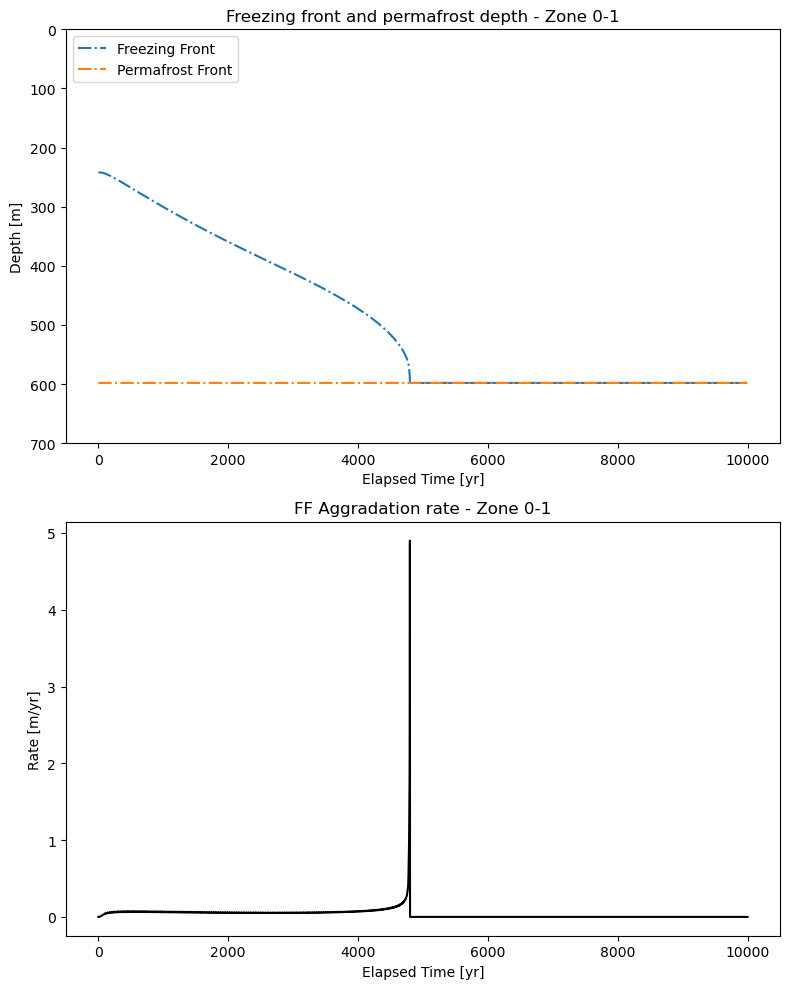

In [18]:
colcount = 1

for col in col_incl:
    if col==1:
        l = runtime  # Runtime [yr]
        k = 0
        zqFF = np.zeros(l)
        zq_1 = np.zeros(l)
        zqPF = np.zeros(l)
        temp = np.zeros((nocell, l))
        tt = np.arange(1, l + 1, t_intv)
        tt_shift = np.arange(1, l, t_intv)
        aggr_rateFF = np.zeros(l-1)
        aggr_rate_1 = np.zeros(l-1)
        aggr_ratePF = np.zeros(l-1)

        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx

            transposed_temp = np.transpose(temp[0:nocell_1, k-1]) # Switches rows and columns
            interp_func = interp1d(transposed_temp, z[0:nocell_1], kind='linear')
            
            if TqFF < np.min(transposed_temp) or TqFF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqFF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqFF)

            zqFF[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if Tq_1 < np.min(transposed_temp) or Tq_1 > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(Tq_1, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(Tq_1)


            zq_1[i] = interpolated_value
            tt[i] = t_intv * k

        k = 0
        for i in range(l):
            k += 1
            temp[0:nocell, k-1] = T_matx_0_1[0:nocell, k-1]  # Use the appropriate T_matx
            
            if TqPF < np.min(transposed_temp) or TqPF > np.max(transposed_temp):
            # Handle the case of values outside the interpolation range
            # For example, use the closest available data point for interpolation
                interpolated_value = interp_func(np.clip(TqPF, np.min(transposed_temp), np.max(transposed_temp)))
            else:
                interpolated_value = interp_func(TqPF)

            zqPF[i] = interpolated_value

        colcount += 1
        presentFFdepth[colcount]=zqFF[len(zqFF)-1]
        presentPFdepth[colcount]=zqPF[len(zqPF)-1]
        DtoDF[colcount]=Dcol1

        no_points = len(zqFF)
        tt_shifted = tt - 0.5 * t_intv
        tt_shift[0:(no_points - 1)] = tt_shifted[1:no_points]
        tt_shift_BP = np.flip(tt_shift)
        tt_flip = np.flip(tt)

        for ii in range(len(zqFF)-1):
            aggr_rateFF[ii] = (zqFF[ii + 1] - zqFF[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_rate_1[ii] = (zq_1[ii + 1] - zq_1[ii]) / t_intv

        for ii in range(len(zqFF)-1):
            aggr_ratePF[ii] = (zqPF[ii + 1] - zqPF[ii]) / t_intv

        presentAggrRate[colcount]=aggr_rateFF[len(aggr_rateFF)-1]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

# Plot the Freezing front and PF depth data in the first subplot
axes[0].plot(tt, zqFF, '-.', label='Freezing Front')
axes[0].plot(tt, zqPF, '-.', label='Permafrost Front')
axes[0].set_title('Freezing front and permafrost depth - Zone 0-1')
axes[0].invert_yaxis()
axes[0].set_xlabel('Elapsed Time [yr]')
axes[0].set_ylabel('Depth [m]')
axes[0].legend(loc='upper left')
axes[0].set_ylim(grid_depth+100, 0)

# Plot the Aggradation rate data in the second subplot
axes[1].plot(tt_shift, aggr_rateFF, 'k')
axes[1].set_title('FF Aggradation rate - Zone 0-1')
axes[1].set_xlabel('Elapsed Time [yr]')
axes[1].set_ylabel('Rate [m/yr]')
#axes[1].legend(loc='upper right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [ ]:
#current problem: no permafrost aggradation
#this is bc zq_1 and zqPF don't change at all. I think this is still an interpolation issue.
#maybe not a problem—I think we only have to track the freezing front

In [18]:
print(zqFF)

[ 18.22483496  25.08997356  30.31763543 ... 598.         598.
 598.        ]


In [19]:
print(zqPF)

[598. 598. 598. ... 598. 598. 598.]


## Final PF and FF depths

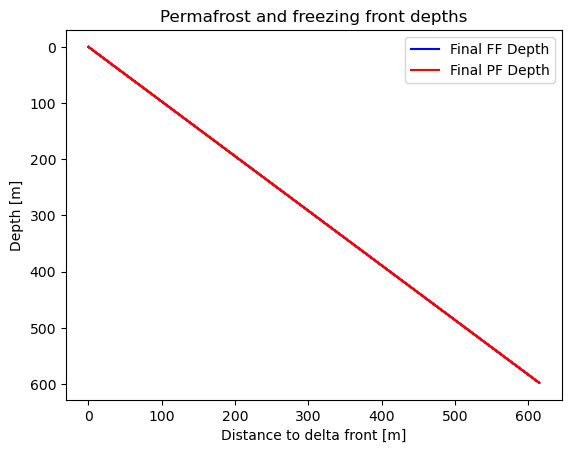

In [21]:
#the DtoDF variable was used in Hornum 2020 to show how ff and pf depths related to distance to delta front at their field site
plt.plot(DtoDF, presentFFdepth, c='blue', label='Final FF Depth')
plt.plot(DtoDF, presentPFdepth, c='red', label='Final PF Depth')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Depth [m]')
plt.title('Permafrost and freezing front depths')
plt.gca().invert_yaxis()
plt.legend(loc='upper right')

## Final Aggradation Rate and Recharge Equivalent

Text(0.5, 1.0, 'Aggradation rate and recharge equivalent')

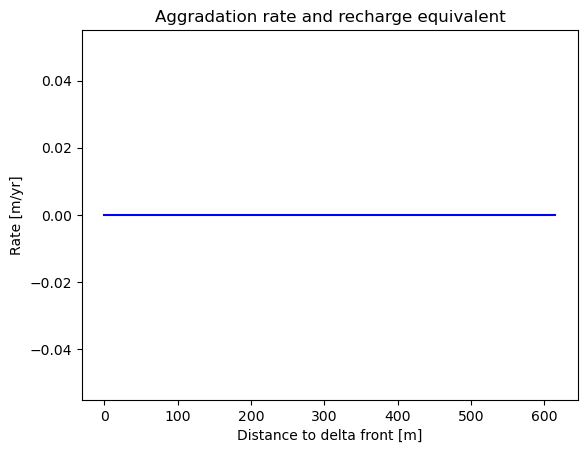

In [22]:
plt.plot(DtoDF[2:], presentAggrRate[2:], c='blue')
plt.xlabel('Distance to delta front [m]')
plt.ylabel('Rate [m/yr]')
plt.title('Aggradation rate and recharge equivalent')

In [ ]:
# next steps: add in temp-dependent material properties? play with diff layers? Investigate FF and PF depths 